In [43]:
import csv
import json

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from xgboost import XGBClassifier

from typing import List, Dict

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold

import lightgbm as lgb

from sklearn.model_selection import learning_curve


In [2]:
def soil_type_2_elu(soil_type: int) -> int:
    assert 0 < soil_type < 41, \
        "Soil type out of boundary 1~40."
    code_dict = [
        2702, 2703, 2704, 2705, 2706,
        2717, 3501, 3502, 4201, 4703,
        4704, 4744, 4758, 5101, 5151,
        6101, 6102, 6731, 7101, 7102,
        7103, 7201, 7202, 7700, 7701,
        7702, 7709, 7710, 7745, 7746,
        7755, 7756, 7757, 7790, 8703,
        8707, 8708, 8771, 8772, 8776,
        ]
    return code_dict[soil_type - 1]


def get_climatic_zone(elu: int) -> int:
    res = elu // 1000
    assert 0 < res <= 8, "Climatic zone code out of boundary 1~8."
    return res


def get_geologic_zone(elu: int) -> int:
    res = elu % 1000 // 100
    assert 0 < res <= 8, "Geologic zone code out of boundary 1~8."
    return res


def get_third_digit(elu: int) -> int:
    return elu % 100 // 10


def get_fourth_digit(elu: int) -> int:
    return elu % 10

In [3]:
def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the dataframe and return [X, y] without reshuffling nor rescaling.
    X is of shape (n,d+2) and y is of shape (n).
    The first column of X contains the ID of each record,
    whilst the second column contains the area code of each record.
    :param mode whether "train" or "test"
    """

    # soil types
    df.insert(loc=0, column="Soil_Type", value=0)
    for i in range(1, 41):
        column_name = "Soil_Type" + str(i)
        df.loc[df[column_name] == 1, "Soil_Type"] = i
        df.drop(column_name, axis=1, inplace=True)

    df["elu"] = [soil_type_2_elu(i) for i in df["Soil_Type"]]
    df.drop("Soil_Type", axis=1, inplace=True)

    df["climatic_zone"] = [get_climatic_zone(i) for i in df["elu"]]
    df["geologic_zone"] = [get_geologic_zone(i) for i in df["elu"]]
    df["third_digit"] = [get_third_digit(i) for i in df["elu"]]
    df["fourth_digit"] = [get_fourth_digit(i) for i in df["elu"]]
    # df.drop("elu", axis=1, inplace=True)

    # wilderness area
    df.insert(loc=0, column="Wilderness_Area", value=0)
    for i in range(1, 5):
        column_name = "Wilderness_Area" + str(i)
        df.loc[df[column_name] == 1, "Wilderness_Area"] = i
        df.drop(column_name, axis=1, inplace=True)

    return df

In [4]:
df_train = pd.read_csv("./data/train.csv")
df_train = preprocess_df(df_train)

In [21]:
def oneHot(df):
    df_oneHot = df.copy()
    for column in ['Wilderness_Area','climatic_zone','geologic_zone','third_digit','fourth_digit']:
        oneHot = pd.get_dummies(df[column], prefix=column)
        #print(oneHot)
        df_oneHot.drop(column,axis=1,inplace = True)
        df_oneHot =df_oneHot.join(oneHot)
    return df_oneHot

def split_aspect(df):
    df_split = df.copy()
    df_split['aspect_m'] = df_split['Aspect'] + 180 - 75
    df_split.loc[df_split['aspect_m']>360, 'aspect_m'] = df_split.loc[df_split['aspect_m']>360,'aspect_m'] - 360
    return df_split

def sqrt_col(df,col):
    df_sqrt = df.copy()
    df_sqrt['sqrt_'+col] = np.sqrt(df[col] + 1)
    return df_sqrt

def drop_id(df):
    df_res = df.drop("Id", axis=1, inplace=False)
    return df_res

def reduce_id(df):
    df_res = df.copy()
    df_res['reduce_id'] = df_res['Id'] // 100
    df_res = df_res.drop('Id',axis=1)
    return df_res

def dist(df):
    df_res = df.copy()
    df_res['Distance'] = np.sqrt(df_res['Horizontal_Distance_To_Hydrology'] ** 2 + df_res['Vertical_Distance_To_Hydrology'] ** 2)
    return df_res

def rel_h(df,col):
    df_res = df.copy()
    df_res['relative_'+col] = df_res[col] / df_res['Elevation']
    return df_res

In [22]:
def further_processing(df_train):
    df_final = split_aspect(df_train)
    df_final = oneHot(df_final)
    df_final = sqrt_col(df_final,'Horizontal_Distance_To_Hydrology')
    df_final = sqrt_col(df_final,'Horizontal_Distance_To_Roadways')
    df_final = sqrt_col(df_final,'Horizontal_Distance_To_Fire_Points')
    df_final = dist(df_final)
    df_final = rel_h(df_final,'Horizontal_Distance_To_Roadways')
    df_final = rel_h(df_final,'Horizontal_Distance_To_Fire_Points')
    #df_final = reduce_id(df_final)
    return df_final

In [23]:
def get_X_y(df_train):
    X = df_train[df_train.columns.difference(['Cover_Type'])]
    y = df_train['Cover_Type']
    return X,y

In [58]:
df_final = further_processing(df_train)
X,y = get_X_y(df_final)
pipeline = Pipeline([
    # ('variance',VarianceThreshold(threshold=(.8 * (1 - .8)))),
                     ('scaler', StandardScaler()),
                     ('classifier', lgb.LGBMClassifier())])

param_grid = {
    'classifier__max_bin': [255],
    'classifier__learning_rate': [0.1],
    'classifier__num_leaves': [63],
    'classifier__n_estimators': [500],
}

model = GridSearchCV(pipeline, param_grid, scoring='accuracy', verbose=3)

model.fit(X, y)
print(model.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__learning_rate=0.1, classifier__max_bin=255, classifier__n_estimators=500, classifier__num_leaves=63;, score=0.894 total time=  23.4s
[CV 2/5] END classifier__learning_rate=0.1, classifier__max_bin=255, classifier__n_estimators=500, classifier__num_leaves=63;, score=0.909 total time=  21.2s
[CV 3/5] END classifier__learning_rate=0.1, classifier__max_bin=255, classifier__n_estimators=500, classifier__num_leaves=63;, score=0.906 total time=  28.9s
[CV 4/5] END classifier__learning_rate=0.1, classifier__max_bin=255, classifier__n_estimators=500, classifier__num_leaves=63;, score=0.907 total time=  21.4s
[CV 5/5] END classifier__learning_rate=0.1, classifier__max_bin=255, classifier__n_estimators=500, classifier__num_leaves=63;, score=0.901 total time=  20.5s
0.9034391534391535


In [52]:
model.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_bin': 255,
 'classifier__n_estimators': 500,
 'classifier__num_leaves': 63}

In [19]:
feature_imp = pd.Series(model.best_estimator_['classifier'].feature_importances_, 
                        index=X.columns).sort_values(ascending=False)

print(sns.barplot(x=feature_imp, y=feature_imp.index))
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Important Features", fontsize=15, pad=15)

ValueError: Length of values (25) does not match length of index (51)

In [20]:
df_test = pd.read_csv("./data/test-full.csv")
df_test = preprocess_df(df_test)
ids = df_test['Id']

In [53]:
df_final_test = further_processing(df_test)
best_model = model.best_estimator_
y_test = best_model.predict(df_final_test[X.columns])
df_result = pd.DataFrame(list(zip(ids, y_test)), columns=['Id', 'Cover_Type'])
df_result.to_csv("./data/lgbm_feature_pred.csv", index=False)

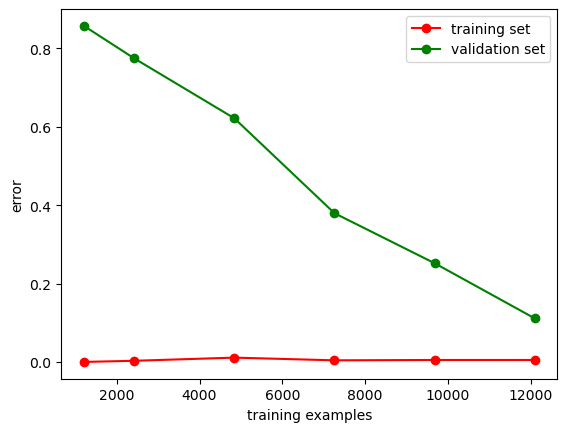

In [57]:
#train_sizes,train_score,test_score = learning_curve(lgb.LGBMClassifier(),X,y,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=5,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training set')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'validation set')
plt.legend(loc='best')
plt.xlabel('training examples')
plt.ylabel('error')
plt.show()